<h1 style="text-align: center;">Python pour le Risk Management</h1>

Dans ce notebook, nous reviendrons sur quelques concepts clés du Risk Management. Après un bref rappel théorique de ces derniers, nous essaierons de les transposer en Python et de les appliquer à des données de marchés.

Parmi ces concepts, nous aborderons les mesures de risque suivantes : 
- La Value-at-Risk
- L'Expected Shortfall
- Le Maximum Drawdown

<p style="background-color: #ededed; padding-left: 20px; padding-right: 20px; padding-top: 15px; padding-bottom: 15px; border-radius: 5px">    
<b>Objectifs :</b><br><br> 
- Acquisition ou révision de concepts de gestion du risque de marché<br>
- Transposition en fonction Python<br>
- Vous aurez pris connaissance et utilisé deux des principales librairies de calcul scientifique de l'univers Python<br>

<br>   
<b>A l'issue de ces travaux vous aurez acquis les compétences suivantes :</b><br><br>
- Modélisation de risque financiers avec python<br>
- Génération de nombres aléatoires à partir de différentes lois de probabilité<br>
- Appris à vectoriser des calculs<br>
</p>


<b>Plan du notebook :</b><br><br>
1. <a href='#VaR'>La Value-at-Risk</a><br>
2. <a href='#ES'>L'Expected Shortfall</a><br>
3. <a href='#MDD'>Le Maximum Drawdown</a><br>
<a href='#annexe'>Annexes</a>

---

### <a id='VaR'>La Value-at-Risk</a> ###

C'est une mesure statistique de la perte d'un portefeuille pour un horizon de temps et un seuil de confiance donnés. Elle est basée sur la notion de quantile d'une distribution de probabilité. Voici l'équation :
<p><br></p>
<p style="background-color: #ededed; padding-left: 20px; padding-right: 20px; padding-top: 15px; padding-bottom: 15px; border-radius: 5px; text-align: center; width:50%; margin:auto;">
$VaR_{1-\alpha}(X) := inf_{t \in \mathbb{R}} \begin{Bmatrix} t : Pr(X \leq t) \geq 1-\alpha \end{Bmatrix}$
<br><br>Avec :<br>
$\alpha$ : l'intervalle de confiance<br>
t : l'horizon temporel
</p>
<p><br></p>


Il existe 3 grandes méthodes pour estimer la VaR. Elles sont décrites dans le tableau ci-dessous avec leurs limites.

|Méthode |Limites|
|:----|:---|
|Méthode **Historique**|Cette méthode est basée sur l'utilisation des données historiques, ce qui permet d'extraire la "vraie" distrubtion des rendements, et de capter les phénomènes d'asymétrie des lois mentionnées juste au-dessus. Cependant, elle nécessite d'avoir des historiques de cours (quid d'une entreprise qui vient d'être introduite en bourse, des cryptos qui viennent d'être créées, etc), et elle présuppose une redondance des événnements passés. Or, nous savons que les évènnements passés ne présagent pas toujours des événnements futurs|
|Méthode de la **Variance-Covariance (paramétrique)**|Cette méthode, qui repose sur l'utilisation de la matrice de variance-covariance, rend les calculs et leurs interprétations aisés, mais ne traduit pas correctement les effets d'asymétrie des lois. Elle repose sur l'hypothèse de normalité de la distribution des rendements, ce qui est peu réaliste|
|Simulation de **Monte-Carlo**|Cette méthode nécessite de faire des hypothèses sur la distribution des rendements. Au delà du caractère "compliqué" de cette exercice, elle suppose également que ces hypothèses restent stable dans le temps, ce qui est peu réaliste|

Maintenant les concepts posés, nous allons développer des fonctions en Python suivant le même ordre que dans le tableau. Pour cela, nous allons avoir besoin de modules Python et de données.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sc
import matplotlib.pyplot as plt

In [4]:
my_path = "C:\\Users\\Come5\\SynoCome\\AVerley\\PRIVATE\\NoteBook\\"
sp100_prices = pd.read_excel(my_path + "sp100_dec2022_prices.xlsx", header=0, index_col=0, parse_dates=True)

---

#### La méthode Historique ####

Pour rappel, ici la méthode est simple, il s'agit de calculer les rendements pour notre horizon de temps (paramètre *duration*), et d'extraire le rendement à un quantile donné (paramètre *alpha*).

In [5]:
def historical_var(prices, alpha, duration):
    duration_returns = prices.pct_change(duration).dropna()
    return duration_returns.quantile(alpha)

In [6]:
# Paramètres de calcul 
ticker = "AMZN.US"
alpha = 0.05
duration = 5

duration_returns = sp100_prices[ticker].pct_change(duration).dropna()
mean = duration_returns.mean()
sigma = duration_returns.std()

In [33]:
h_var = historical_var(sp100_prices[ticker], alpha, duration)
print(f"La VaR historique pour {ticker}, à {duration} jours et au seuil de probabilité de {alpha:.2%} est de : {h_var:.2%}")

La VaR historique pour AMZN.US, à 5 jours et au seuil de probabilité de 5.00% est de : -10.87%


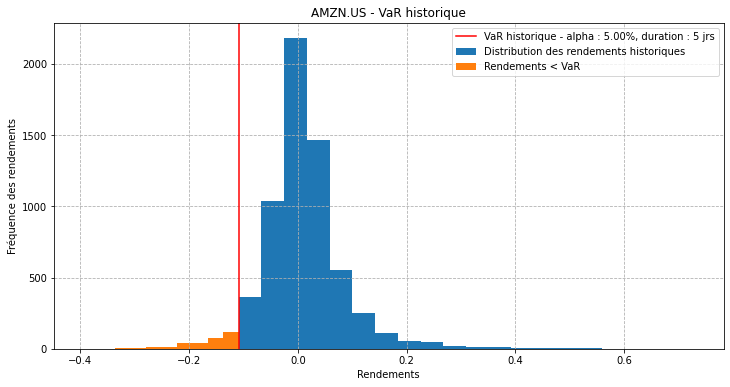

In [34]:
plt.figure(figsize=(12,6))
plt.hist(duration_returns[duration_returns > h_var], bins=20)
plt.hist(duration_returns[duration_returns < h_var], bins=10)
plt.axvline(h_var, color='red', linestyle='solid');
plt.legend([
    f"VaR historique - alpha : {alpha:.2%}, duration : {duration} jrs",
    "Distribution des rendements historiques", 
    'Rendements < VaR'
])
plt.grid(linestyle="--")
plt.title(f"{ticker} - VaR historique");
plt.xlabel('Rendements');
plt.ylabel('Fréquence des rendements');

>Notez qu'il est facile de **vectoriser** ce calcul pour estimer les VaR unitaires d'un univers de titres. Ce concept est important, car il permet souvent de rendre le code plus lisible, et surtout **d'améliorer les performances de calcul**, car Python est excellent dans ce cas là.

In [35]:
VaRs = historical_var(sp100_prices[["AAPL.US","MSFT.US","HD.US","WMT.US","BAC.US","PG.US"]], alpha, duration)
VaRs

AAPL.US   -0.083882
MSFT.US   -0.064113
HD.US     -0.062343
WMT.US    -0.051484
BAC.US    -0.075816
PG.US     -0.041538
Name: 0.05, dtype: float64

---

#### La méthode de la Variance-Covariance ####
(ou VaR paramétrique)

Dans ce cas, nous allons prendre l'exemple d'un portefeuille composé des 6 actions comme suit :
- Apple (AAPL.US) : 15%
- Microsoft (MSFT.US) : 20%
- The Home Depot (HD.US) : 10%
- Walmart (WMT.US) : 25%
- Bank of America (BAC.US) : 15%
- Procter & Gamble (PG.US) : 15%

Dans la fonction ci-dessous, il est possible d'utiliser des distributions selon deux lois de probabilité (Normale et Student). La deuxième (Student) permet d'avoir des distributions avec des ***fat tails***. Mais il est évidemment possible de faire appel à d'autres distributions pour raffiner l'analyse. Une des limitations de la loi de Student, c'est qu'elle est symétrique, or nous savons que sur les marchés financiers, les distributions de rendements le sont rarement.

In [13]:
def parametrique_var(prices, vec_w, alpha, duration, distrib):
    # rendements nécessaires au calcul de la matrice de variance-covariance
    duration_returns = prices.pct_change(duration).dropna()
    
    if vec_w == None:
        mean_return = duration_returns.mean()
        sigma = duration_returns.std()
    else:
        # IMPORTANT : ci-dessous, les calculs sont VECTORISES
        # rendement du portefeuille, pondéré des poids de chaque action
        mean_return = np.dot(vec_w, duration_returns.mean())     
        varcov_mat = duration_returns.cov() # matrice de variance-covariance
        sigma = np.sqrt(np.dot(np.dot(vec_w, varcov_mat), vec_w)) # volatilité du portefeuille
    
    if distrib == "normal":
        var = sc.norm.ppf(q=alpha, loc=mean_return, scale=sigma)
    else:
        if vec_w != None:  # Méthode pour un portefeuille de titres
            params = sc.t.fit(np.dot(duration_returns, vec_w))
            var = sc.t.ppf(q=alpha, df=params[0], loc=mean_return, scale=sigma)
        else:  # Méthode pour un titre unique
            params = sc.t.fit(duration_returns)
            var = sc.t.ppf(q=alpha, df=params[0], loc=mean_return, scale=sigma)
    return var

Pour rappel, comme la distribution est symétrique alors le skewness est égale à 0, et le seul paramètre à définir est le **degré de liberté** (duquel va dépendre l'épaisseur de la queue de distribution). Pour améliorer l'estimation de la VaR par cette méthode, il est donc important d'utiliser une distribution la plus proche possible de la réalité (i.e notre jeu de données) c'est pourquoi nous estimons ses paramètres par maximum de vraisemblance (Maximum Likelihood Estimation ou MLE) et on utilise ces derniers au moment de générer la nouvelle distribution.

C'est ce qu'on peut voir dans les lignes ci-dessous :
>params = sc.t.fit(duration_returns)
>
>var = sc.t.ppf(q=alpha, df=params[0], loc=mean_return, scale=sigma)

La commande sc.t.fit(duration_returns) permet d'extraire les paramètres de la distribution à partir des rendements historiques, et ces paramètres sont :
- params[0] = degrés de liberté
- params[1] = la moyenne des rendements
- params[2] = l'écart-type des rendements

Nous aurions pu utiliser tous ces paramètres dans la fonction sc.t.ppf de la manière suivante : 
>var = sc.t.ppf(q=alpha, df=params[0], loc=params[1], scale=params[2])

Je n'ai pas utilisé ces paramètres car :
- Les paramètres extraits par MLE sont proches de ceux estimés avec notre méthode, c'est pourquoi on obtient des résultats similaires peu importe la méthode.
- L'utilisation des paramètres calculés par nos soins (mean_return, sigma) permet une meilleure lisibilité et une meilleure compréhension des paramètres et des composantes de la fonction.

Ci-dessous, nous estimons la VaR pour un portefeuille d'actifs :

In [14]:
tickers = ["AAPL.US","MSFT.US","HD.US","WMT.US","BAC.US","PG.US"]
weights = [0.15, 0.2, 0.1, 0.25, 0.15, 0.15]

param_var = parametrique_var(sp100_prices[tickers], weights, alpha, duration, 'normal')
print(f"La VaR paramétrique (distribution Normale) de notre portefeuille, à {duration} jours et au seuil de probabilité de {alpha:.2%} est de : {param_var:.2%}")

param_var2 = parametrique_var(sp100_prices[tickers], weights, alpha, duration,"student")
print(f"La VaR paramétrique (distribution Student) de notre portefeuille, à {duration} jours et au seuil de probabilité de {alpha:.2%} est de : {param_var2:.2%}")

La VaR paramétrique (distribution Normale) de notre portefeuille, à 5 jours et au seuil de probabilité de 5.00% est de : -4.38%
La VaR paramétrique (distribution Student) de notre portefeuille, à 5 jours et au seuil de probabilité de 5.00% est de : -5.74%


Voyons les résultats si nous utilisons cette méthode sur le titre Amazon (comme au premier exemple) :

In [38]:
norm_var = parametrique_var(sp100_prices[ticker], None, alpha, duration, 'normal')
print(f"La VaR paramétrique (distribution normale) pour {ticker}, à {duration} jours et au seuil de probabilité de {alpha:.2%} est de : {norm_var:.2%}")

stud_var = parametrique_var(sp100_prices[ticker], None, alpha, duration, 'student')
print(f"La VaR paramétrique (distribution t-student) pour {ticker}, à {duration} jours et au seuil de probabilité de {alpha:.2%} est de : {stud_var:.2%}")

La VaR paramétrique (distribution normale) pour AMZN.US, à 5 jours et au seuil de probabilité de 5.00% est de : -12.59%
La VaR paramétrique (distribution t-student) pour AMZN.US, à 5 jours et au seuil de probabilité de 5.00% est de : -21.11%


>Lorsque on intègre une distribution permettant des queues de distributions épaisses (leptokurtique), on voit naturellement la VaR augmenter drastiquement.
>Cette méthode reste imparfaite car la distribution de student repose sur l'hypothèse que les rendements sont iid, ce qui n'est pas réaliste. Cela conduit à surestimer la VaR en période de marché normaux, et à la sous estimer lors des phases de stress.

Pour mettre en lumière la différence entre une distribution normale et une distribution de student, je trace les distributions des deux lois en utilisant les mêmes paramètres de rendement et de volatilité.

degrés de liberté pour notre jeu de données : 2.283210735799197


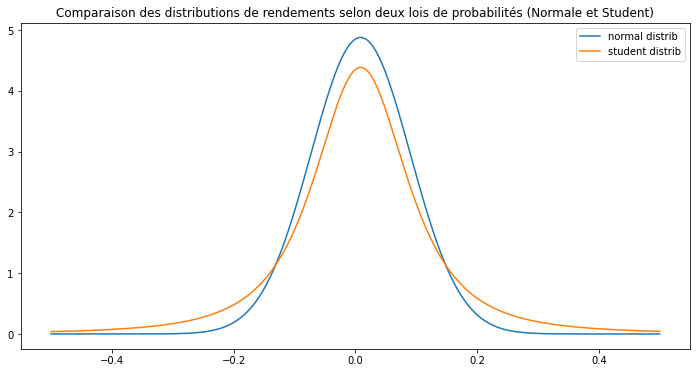

In [40]:
student_fit = sc.t.fit(duration_returns)
tdof = student_fit[0]
print(f"degrés de liberté pour notre jeu de données : {tdof}")
x = np.linspace(-0.5, 0.5, 1000)
normal_distrib = sc.norm.pdf(x, mean, sigma) 
t_distrib = sc.t.pdf(x, tdof, mean, sigma)
plt.figure(figsize=(12,6))
plt.plot(x, normal_distrib, label='normal distrib')
plt.plot(x, t_distrib, label='student distrib')
plt.legend()
plt.title("Comparaison des distributions de rendements selon deux lois de probabilités (Normale et Student)");

>Plus le degré de liberté converge vers 0, plus les queues de distribution d'une loi de Student seront importantes. Pour démontrer ce phénomène je vais utiliser deux distributions utilisant les mêmes paramètres de rendement et de volatilité, mais en changeant uniquement le paramètre du degré de liberté :

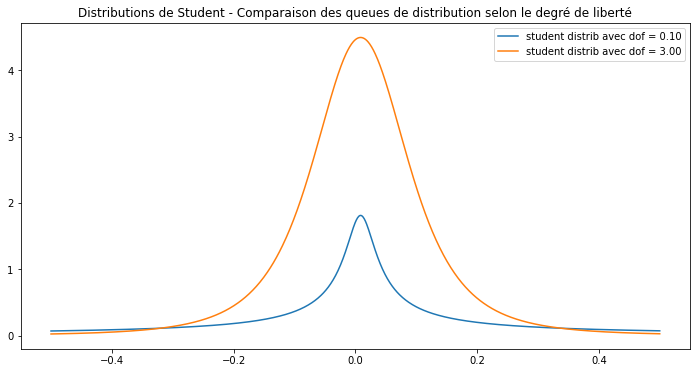

In [41]:
dof_val = [0.1,3.0]

plt.figure(figsize=(12,6))
#plt.plot(x, normal_distrib, label='normal distrib')
for dof in dof_val:
    t_distrib = sc.t.pdf(x, dof, mean, sigma)
    plt.plot(x, t_distrib, label=f"student distrib avec dof = {dof:.2f}")
    plt.legend()
    plt.title("Distributions de Student - Comparaison des queues de distribution selon le degré de liberté");

Plus le degré de liberté va tendre vers l'inifinie, plus la distribution de Student tendra vers une distribution normale !

---

#### La simulation de Monte-Carlo ####

Pour cette méthode, nous faisons l'hypothèse que le prix des actions suit un mouvement brownien géométrique, ce qui est le modèle le plus communément utilisé par les praticiens des marchés. 

In [17]:
def random_walk(startprice, mu, sigma, days, distrib):
    days = days + 1
    dt = 1/float(days) 
    
    # initialisation des données
    price = np.zeros(days)
    shock = np.zeros(days)
    price[0] = startprice
    
    for i in range(1, days):
        if distrib == "normal":
            shock[i] = np.random.normal(loc=mu * dt, scale=sigma * np.sqrt(dt))
        else:
            shock[i] = sc.t.rvs(np.max([1.0, days-1.0]), loc=mu * dt, scale=sigma * np.sqrt(dt), size=1)
        price[i] = max(0, price[i-1] + shock[i] * price[i-1])
    return price

In [18]:
# Avec cette fonction on va effectuer num simulations et les insérer dans une variable
def multiple_path(num, startprice, mu, sigma, days, distrib):
    simulations = []
    for i in range(0, num-1):
        simulations.append(random_walk(startprice, mu, sigma, days, distrib))
    return simulations

In [19]:
def mc_var(num, startprice, mu, sigma, alpha, duration, distrib):
    multi_path = multiple_path(num, startprice, mean, sigma, duration, distrib)
    return np.quantile(multi_path, alpha)/100-1

In [20]:
monte_carlo_norm = mc_var(10000, 100, mean, sigma, alpha, duration, 'normal')
print(f"La VaR Monte-Carlo (distribution normale) pour {ticker}, à {duration} jours et au seuil de probabilité de {alpha:.2%} est de : {monte_carlo_norm:.2%}")

monte_carlo_stud = mc_var(10000, 100, mean, sigma, alpha, duration, 'student')
print(f"La VaR Monte-Carlo (distribution student) pour {ticker}, à {duration} jours et au seuil de probabilité de {alpha:.2%} est de : {monte_carlo_stud:.2%}")

La VaR Monte-Carlo (distribution normale) pour AMZN.US, à 5 jours et au seuil de probabilité de 5.00% est de : -8.44%
La VaR Monte-Carlo (distribution student) pour AMZN.US, à 5 jours et au seuil de probabilité de 5.00% est de : -10.74%


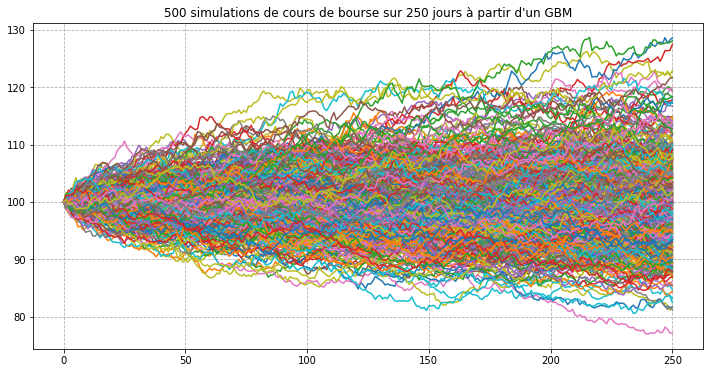

In [21]:
sim = multiple_path(500, 100, mean, sigma, 250, 'normal') 
plt.figure(figsize=(12,6))
plt.plot(np.transpose(sim))
plt.grid(linestyle="--")
plt.title("500 simulations de cours de bourse sur 250 jours à partir d'un GBM");

#### Comparaison des résultats : ###

In [47]:
print(f"VaR({ticker}) avec les paramètres suivants : alpha : {alpha:.2%} et horizon de temps : {duration} jours")
print(f"La VaR Historique                 : {h_var:.2%}")
print(f"La VaR paramétrique (loi Normale) : {norm_var:.2%}")
print(f"La VaR paramétrique (loi Student) : {stud_var:.2%}")
print(f"La VaR Monte-Carlo  (loi Normale) : {monte_carlo_norm:.2%}")
print(f"La VaR Monte-Carlo  (loi Student) : {monte_carlo_stud:.2%}")

VaR(AMZN.US) avec les paramètres suivants : alpha : 5.00% et horizon de temps : 5 jours
La VaR Historique                 : -10.87%
La VaR paramétrique (loi Normale) : -12.59%
La VaR paramétrique (loi Student) : -21.11%
La VaR Monte-Carlo  (loi Normale) : -8.35%
La VaR Monte-Carlo  (loi Student) : -10.50%


Les résultats montrent des différences significatives :
- La VaR paramétrique en loi de Student semble exagérer le risque
- La VaR Monte-Carlo en loi Normale semble sous estimer le risque
- La VaR Monte-Carlo en loi de Student semble le candidat le plus proche de la réalité

---

### <a id='ES'>L'Expected Shortfall</a> ###

La VaR est une mesure de risque qui ne prend en compte que la probabilité d'être en dessous d'un niveau donné, et ne fait pas intervenir les valeurs en dessous de ce niveau, ou même leur moyenne. Ce faisant, nous n'avons aucune idée du niveau de perte que l'on peut encourir si l'on dépasse ce niveau.

De plus, la VaR n'est pas une mesure de risque cohérente, car elle n'est pas sous-additive. Concrètement, cela veut dire qu'elle prend mal en compte la réduction du risque apportée par la diversification dans un portefeuille de titres : VaR(A + B) > VaR(A) + VaR(B).
Elle devient sous-additive uniquement lorsque la distribution jointe des titres est gaussienne.

Pour dépasser ces limites, nous allons étudier l'*Expected Shortfall* (aussi appelée *CVaR*, pour *Conditional Value-at-Risk* ou *TailVaR*).

l’expected shortfall est la perte probable quand on se trouve dans les α% scénario de la queue de la distribution des pertes. Il s'agit de l'espérance conditionnelle des pertes au delà du niveau de la VaR.

De la même manière que vu plus haut, il existe plusieurs méthodes d'estimation (historique, paramétrique et par simulation de MC).

L'équation de l'Expected Shortfall est la suivante :

<p><br></p>
<p style="background-color: #ededed; padding-left: 20px; padding-right: 20px; padding-top: 15px; padding-bottom: 15px; border-radius: 5px; text-align: center; width:50%; margin:auto;">
$CVaR_{1-\alpha}(X) := \frac{1}{\alpha} \int_{0}^{\alpha} VaR_{1-\gamma}(X) d\gamma$
</p>
<p><br></p>

Ce lien vous permettra d'accéder à un page wikipedia très exhaustive sur le sujet. Vous trouverez notamment les formules fermées de l'ES pour les différentes distributions : https://en.wikipedia.org/wiki/Expected_shortfall

---

#### La méthode historique ####

In [48]:
def historical_es(prices, alpha, duration):
    duration_returns = prices.pct_change(duration).dropna()
    var = duration_returns.quantile(alpha)
    return duration_returns[duration_returns <= var].mean()

In [49]:
h_es = historical_es(sp100_prices[ticker], alpha, duration)
print(f"L'ES historique pour {ticker}, à {duration} jours et au seuil de probabilité de {alpha:.2%} est de : {h_es:.2%}")

L'ES historique pour AMZN.US, à 5 jours et au seuil de probabilité de 5.00% est de : -16.68%


Il est également possible de vectoriser ce calcul :

In [50]:
historical_es(sp100_prices[["AAPL.US","MSFT.US","HD.US","WMT.US","BAC.US","PG.US"]], alpha, duration)

AAPL.US   -0.127417
MSFT.US   -0.095145
HD.US     -0.096890
WMT.US    -0.076925
BAC.US    -0.123216
PG.US     -0.066047
dtype: float64

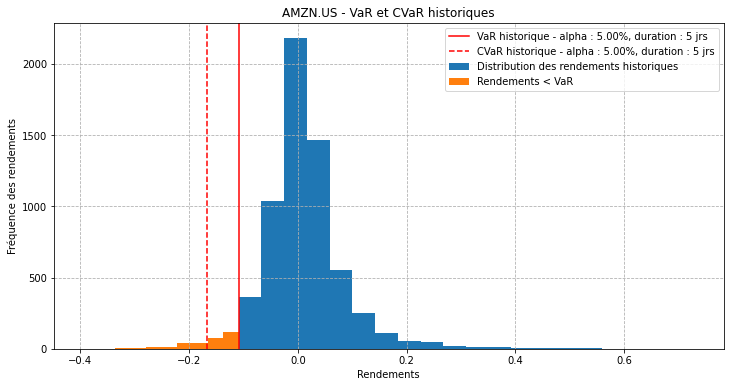

In [51]:
plt.figure(figsize=(12,6))
plt.hist(duration_returns[duration_returns > h_var], bins=20)
plt.hist(duration_returns[duration_returns < h_var], bins=10)
plt.axvline(h_var, color='red', linestyle='solid');
plt.axvline(h_es, color='red', linestyle='dashed');
plt.legend([
    f"VaR historique - alpha : {alpha:.2%}, duration : {duration} jrs",
    f"CVaR historique - alpha : {alpha:.2%}, duration : {duration} jrs",
    "Distribution des rendements historiques", 
    'Rendements < VaR'
])
plt.grid(linestyle="--")
plt.title(f"{ticker} - VaR et CVaR historiques");
plt.xlabel('Rendements');
plt.ylabel('Fréquence des rendements');


#### La méthode paramétrique ####

In [52]:
def parametrique_es(prices, vec_w, alpha, duration):
    duration_returns = prices.pct_change(duration).dropna()
    if vec_w == None:
        mean_return = duration_returns.mean()
        sigma = duration_returns.std()
    else:
        mean_return = np.dot(vec_w, duration_returns.mean())
        varcov_mat = duration_returns.cov() 
        sigma = np.sqrt(np.dot(np.dot(vec_w, varcov_mat), vec_w)) 
    
    es = -sigma*sc.norm.pdf(sc.norm.ppf(alpha))/(alpha)+mean_return
    return es

In [53]:
param_es = parametrique_es(sp100_prices[ticker], None, alpha, duration)
print(f"L'ES paramétrique pour {ticker}, à {duration} jours et au seuil de probabilité de {alpha:.2%} est de : {param_es:.2%}")

L'ES paramétrique pour AMZN.US, à 5 jours et au seuil de probabilité de 5.00% est de : -16.01%


In [54]:
param_ptf_es = parametrique_es(sp100_prices[tickers], weights, alpha, duration)
print(f"L'ES historique pour {tickers}, à {duration} jours et au seuil de probabilité de {alpha:.2%} est de : {param_ptf_es:.2%}")

L'ES historique pour ['AAPL.US', 'MSFT.US', 'HD.US', 'WMT.US', 'BAC.US', 'PG.US'], à 5 jours et au seuil de probabilité de 5.00% est de : -5.60%


#### La simulation de Monte-Carlo ####

Pour ce caclul, nous allons réutiliser la fonction multiple_path(), qui permet de simuler des évolutions de cours de bourse selon un mouvement brownien géométrique.

In [55]:
def mc_es(num, startprice, mu, sigma, alpha, duration, distrib):
    multi_path = np.asarray(multiple_path(num, startprice, mu, sigma, duration, distrib)) # simulation des MBG 
    
    # création d'une matrice aux mêmes dimensions que notre matrice de simulations
    div_matrix = np.full(multi_path.shape, startprice) 
    returns = multi_path / div_matrix - 1. # calcul des rendements cumulés sur la période
    var_threeshold = np.quantile(returns, alpha) # extraction du seuil de la VaR
    
    # extraction des indices où le rendement cumulé final est en dessous du seuil
    below_var = np.where(returns[:,-1] <= var_threeshold)[0] 
    return np.mean(returns[below_var,-1])

In [56]:
mc_norm_es = mc_es(10000, 100, mean, sigma, 0.05, duration, 'normal')
print(f"L'ES par Monte-Carlo (loi Normale) pour {tickers}, à {duration} jours et au seuil de probabilité de {alpha:.2%} est de : {mc_norm_es:.2%}")

mc_stud_es = mc_es(10000, 100, mean, sigma, 0.05, duration, 'student')
print(f"L'ES par Monte-Carlo (loi de Student) pour {tickers}, à {duration} jours et au seuil de probabilité de {alpha:.2%} est de : {mc_stud_es:.2%}")

L'ES par Monte-Carlo (loi Normale) pour ['AAPL.US', 'MSFT.US', 'HD.US', 'WMT.US', 'BAC.US', 'PG.US'], à 5 jours et au seuil de probabilité de 5.00% est de : -11.72%
L'ES par Monte-Carlo (loi de Student) pour ['AAPL.US', 'MSFT.US', 'HD.US', 'WMT.US', 'BAC.US', 'PG.US'], à 5 jours et au seuil de probabilité de 5.00% est de : -15.16%


#### Comparaison des résultats ####

In [57]:
print(f"l'Expected Shortfall ({ticker}) avec les paramètres suivants : alpha : {alpha:.2%} et horizon de temps : {duration} jours")
print(f"L'ES Historique                   : {h_es:.2%}")
print(f"L'ES paramétrique (loi Normale)   : {param_es:.2%}")
print(f"La VaR Monte-Carlo  (loi Normale) : {mc_norm_es:.2%}")
print(f"La VaR Monte-Carlo  (loi Student) : {mc_stud_es:.2%}")

l'Expected Shortfall (AMZN.US) avec les paramètres suivants : alpha : 5.00% et horizon de temps : 5 jours
L'ES Historique                   : -16.68%
L'ES paramétrique (loi Normale)   : -16.01%
La VaR Monte-Carlo  (loi Normale) : -11.72%
La VaR Monte-Carlo  (loi Student) : -15.16%


A part pour l'Expected Shortfall calulé à partir des simulations de Monte-Carlo à partir de rendements suivants une loi Normale, les autres métriques semblent proches de l'ES historique.

### <a id='MDD'>La Maximum Drawdown</a> ###

Le Maximum Drawdown est la perte successive maximale sur un historique d'analyse. Comme nous le verrons il est possible de mesurer l'évolution des drawdowns à travers le temps, et de mesurer le 'time to recovery' lors des phases de drawdowns (cette partie n'est pas implémentée dans ce notebook).

In [58]:
def drawdowns_timeseries(prices):
    return (prices / prices.cummax() - 1)

In [59]:
def maximum_drawdown(prices):
    return drawdowns_timeseries(prices).min()    

Ici, les fonctions sont produites en utilisant les méthodes de pandas, ce qui nous permet de garder les propriétés de notre classe de départ, càd le pandas.DataFrame().

Ci-dessous, le maximum drawdown pour les titres de notre univers :

In [60]:
mdd_univ = maximum_drawdown(sp100_prices[["AAPL.US","MSFT.US","HD.US","WMT.US","BAC.US","PG.US"]].tail(250)) # je garde uniquement les 500 derniers cours
mdd_univ

AAPL.US   -0.298248
MSFT.US   -0.317698
HD.US     -0.298043
WMT.US    -0.257397
BAC.US    -0.386672
PG.US     -0.237723
dtype: float64

Ci-dessous, l'évolution du drawdown de notre univers d'actions sur les 250 derniers jours :

In [61]:
ts_mdd_univ = drawdowns_timeseries(sp100_prices[["AAPL.US","MSFT.US","HD.US","WMT.US","BAC.US","PG.US"]].tail(250))

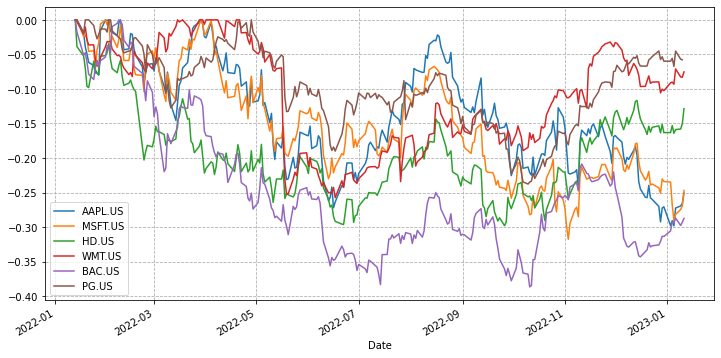

In [62]:
ts_mdd_univ.plot(figsize=(12, 6))
plt.grid(linestyle="--")

>Notez que si nous avons les séries temporelles des drawdowns, nous pouvons utiliser la méthode pd.DataFrame().agg() pour extraire des statistiques sur nos données. De cette manière, nous pouvons extraire le maximum drawdown et la moyenne des drawdowns.

In [ ]:
ts_mdd_univ.agg(['min','mean'])

<a id='annexe'><h2 style="text-align: center;">ANNEXES</h2></a>

Les propriétés nécessaires pour qu'une mesure de risque soit cohérente :
1. Soient $X, Y \in \chi$, si $X \leq Y$ p.s. alors $p(X) \leq p(Y)$ (Monotonicité).
2. Soient $X \in \chi$ et $b \in \mathbb{R}$, on a $p(X+b) = p(X) + b$ (Invariance par translation).
3. Soient $X \in \chi$ et $c \geq 0$, on a $p(cX) = c*p(X)$ (Homogénéité positive).
4. Soient $X, Y \in \chi$, on a $p(X+Y) \leq p(X) + p(Y)$ (Sous-additivité).
